In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Is gpu available?', device=='cuda')
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
#from transformers import pipeline
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
from datasets import load_dataset

Is gpu available? True


In [7]:
lab2idx = {}
idx2lab = {}
i = 0
with open('../data/emotions.txt','r') as f:
    for line in f:
        lab2idx[line.strip()]=i
        idx2lab[i] = line.strip()
        i+=1
labels = list(lab2idx.keys())

dataset = load_dataset("csv",data_files=
                       {"train": "../reformat_data/train_wide.csv",
                        "validation": "../reformat_data/val_wide.csv",
                         "test": "../reformat_data/test_wide.csv"})

Found cached dataset csv (C:/Users/lkkcp/.cache/huggingface/datasets/csv/default-af6254ecd422efea/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
model_checkpoint = "roberta-base"
MAXLEN = 256
batch_size = 4
metric_name = 'f1'
epochs = 25
weight_decay = 0.01
learning_rate = 1e-5

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
def encode(samples):
    return tokenizer(samples['Text'], padding="max_length",truncation=True, max_length=MAXLEN)
def label_formatting(samples):
    labels_matrix = np.zeros((len(samples['Text']), len(labels)))
    for i, label in enumerate(labels):
        labels_matrix[:,i] = samples[label]
    return {'labels':labels_matrix.tolist()}

temp = dataset.map(encode,batched=True)
encoded_dataset = temp.map(label_formatting,batched=True,remove_columns=dataset['train'].column_names)
encoded_dataset.set_format("torch")

Loading cached processed dataset at C:\Users\lkkcp\.cache\huggingface\datasets\csv\default-af6254ecd422efea\0.0.0\eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d\cache-e8fc3e634a7da0cb.arrow


Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Loading cached processed dataset at C:\Users\lkkcp\.cache\huggingface\datasets\csv\default-af6254ecd422efea\0.0.0\eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d\cache-582714c08f6ac1c0.arrow
Loading cached processed dataset at C:\Users\lkkcp\.cache\huggingface\datasets\csv\default-af6254ecd422efea\0.0.0\eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d\cache-71fef9d4e0c90e46.arrow


Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Loading cached processed dataset at C:\Users\lkkcp\.cache\huggingface\datasets\csv\default-af6254ecd422efea\0.0.0\eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d\cache-91ac5c28bfcad1cd.arrow


In [10]:
def multi_label_metrics(predictions, true_labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = true_labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        true_labels=p.label_ids)
    return result

In [11]:
def train_with_data_size(size):
    encoded_train_subset = encoded_dataset['train'].select(range(size))
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=idx2lab,
                                                           label2id=lab2idx).to(device)
    
    
    args = TrainingArguments(
        f"{model_checkpoint}-goemotions",
        evaluation_strategy = "epoch",
        logging_strategy = "epoch",
        save_strategy = "no",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        #load_best_model_at_end=True,
        #metric_for_best_model=metric_name,
        #push_to_hub=True,
    )
    
    trainer = Trainer(
        model,
        args,
        train_dataset=encoded_train_subset,
        eval_dataset=encoded_dataset["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    
    metric_history = trainer.train()
    hist = trainer.state.log_history
    i= np.argmin([d.get('eval_loss',float('inf')) for d in hist])
    res = hist[i].copy()
    res['data_size'] = size
    return res

In [12]:
log = []
for size in [100,300,1000,3000,10000]:
    log.append(train_with_data_size(size))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\lkkcp\PycharmProjects\GoEmotions\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.630800,0.521201,0.066291,0.510344,0.013638
2,0.446200,0.352463,0.040211,0.509716,0.021931
3,0.335100,0.283882,0.000000,0.500000,0.000000
4,0.276900,0.246242,0.000000,0.500000,0.000000
5,0.243900,0.223776,0.000000,0.500000,0.000000
6,0.222400,0.208848,0.000000,0.500000,0.000000
7,0.207000,0.198077,0.000000,0.500000,0.000000
8,0.196900,0.190306,0.000000,0.500000,0.000000
9,0.188900,0.184316,0.000000,0.500000,0.000000
10,0.182400,0.179764,0.000000,0.500000,0.000000


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\lkkcp\PycharmProjects\GoEmotions\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.464700,0.278669,0.000000,0.500000,0.000000
2,0.241000,0.200543,0.000000,0.500000,0.000000
3,0.190700,0.176019,0.000000,0.500000,0.000000
4,0.171400,0.164664,0.000000,0.500000,0.000000
5,0.161300,0.159144,0.000000,0.500000,0.000000
6,0.155300,0.154798,0.000000,0.500000,0.000000
7,0.150300,0.151365,0.000000,0.500000,0.000000
8,0.145400,0.149041,0.047316,0.512026,0.027460
9,0.140600,0.147753,0.278911,0.589551,0.192223
10,0.134200,0.146071,0.240961,0.573237,0.152967


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\lkkcp\PycharmProjects\GoEmotions\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.284700,0.169192,0.000000,0.500000,0.000000
2,0.161300,0.152719,0.000000,0.500000,0.000000
3,0.150200,0.145313,0.000000,0.500000,0.000000
4,0.140100,0.138244,0.193243,0.554987,0.122374
5,0.127800,0.129402,0.334283,0.608160,0.227976
6,0.115100,0.127354,0.381272,0.630734,0.265757
7,0.103000,0.124634,0.403054,0.638159,0.274604
8,0.093900,0.120637,0.413831,0.645607,0.298562
9,0.085400,0.118535,0.428027,0.651057,0.306303
10,0.078700,0.119030,0.428541,0.652871,0.299300


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\lkkcp\PycharmProjects\GoEmotions\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.197400,0.143562,0.004064,0.501005,0.002396
2,0.136200,0.129089,0.181920,0.550498,0.100811
3,0.116100,0.115920,0.469944,0.677652,0.360855
4,0.099500,0.109929,0.467862,0.671662,0.345927
5,0.087200,0.107017,0.484073,0.684253,0.365831
6,0.076100,0.106236,0.485873,0.684244,0.369149
7,0.067000,0.106614,0.525468,0.714774,0.420383
8,0.059700,0.108253,0.515458,0.715431,0.407851
9,0.053300,0.113500,0.519616,0.724031,0.417066
10,0.047800,0.113140,0.529559,0.733091,0.435127


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\lkkcp\PycharmProjects\GoEmotions\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.150000,0.110984,0.458758,0.667804,0.344268
2,0.102400,0.097370,0.493817,0.681871,0.358644
3,0.086800,0.093022,0.532535,0.711953,0.415039
4,0.075300,0.094465,0.541115,0.720879,0.430888
5,0.065700,0.100676,0.563938,0.742062,0.470328
6,0.057200,0.105358,0.547204,0.740468,0.450977
7,0.050300,0.108042,0.547088,0.741152,0.449502
8,0.043800,0.113161,0.548935,0.750432,0.451898
9,0.038400,0.118876,0.542682,0.748297,0.444711
10,0.033800,0.122922,0.532712,0.742422,0.436233


In [13]:
log_df = pd.DataFrame(log)
log_df.to_csv('performances_vs_data_size.csv')

In [15]:
log_df.head(5)

,eval_loss,eval_f1,eval_roc_auc,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,data_size
0,0.161240,0.000000,0.500000,0.000000,143.9288,37.699,9.428,25.0,625,100
1,0.136343,0.305760,0.598459,0.205123,129.5030,41.899,10.479,22.0,1650,300
2,0.115688,0.484657,0.692816,0.373940,110.3420,49.174,12.298,17.0,4250,1000
3,0.106236,0.485873,0.684244,0.369149,106.4991,50.949,12.742,6.0,4500,3000
4,0.093022,0.532535,0.711953,0.415039,107.9291,50.274,12.573,3.0,7500,10000


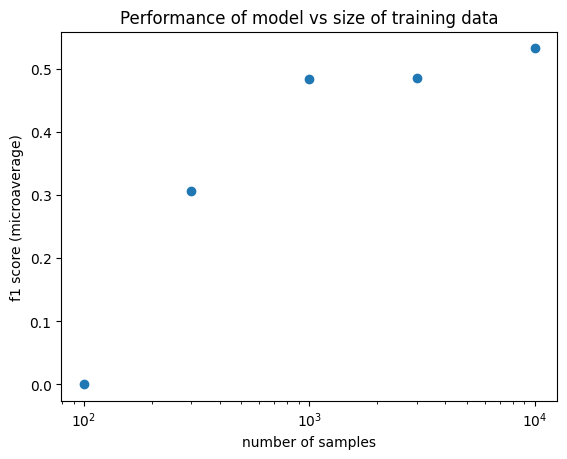

In [16]:
plt.scatter(log_df['data_size'], log_df['eval_f1'])
plt.xscale('log')
plt.xlabel('number of samples')
plt.ylabel('f1 score (microaverage)')
plt.title('Performance of model vs size of training data')
plt.show()

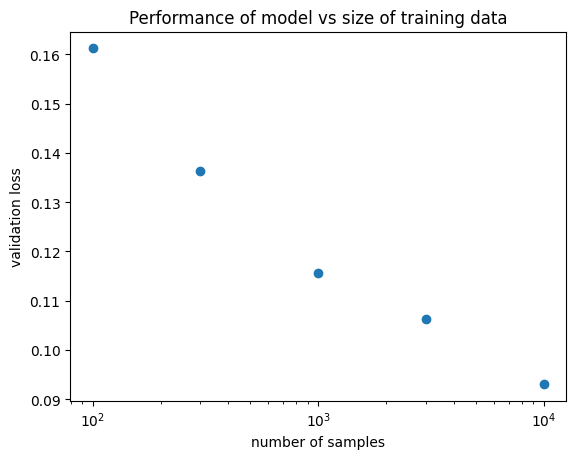

In [18]:
plt.scatter(log_df['data_size'], log_df['eval_loss'])
plt.xscale('log')
plt.xlabel('number of samples')
plt.ylabel('validation loss')
plt.title('Performance of model vs size of training data')
plt.show()